In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time, sys, os
import pickle

from utils import geometry2
from utils import load_utils
from utils import plot_utils
from utils.expectationMaximizationModel import expectationMaximization
from utils.particleFilter import allom_map
from utils.particleFilter import allom

# Data

In [7]:
PATH_MAP = "./data/map.json"
PATH_SEQ = "./data/seq1_night1.json"
GAM_PATH = './data/gam.pickle'

#FEAT_SUFFIX = '-NetVLAD_layer.h5' # Not available
FEAT_SUFFIX = '-ImRet_R101gw.h5'

Loaded poses: 4111 feats: 4111 odoms: 0
Loaded poses: 1911 feats: 1911 odoms: 1911


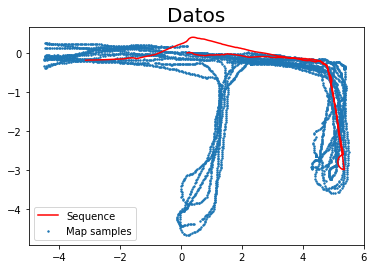

In [8]:
# Map
seq_dict_map = load_utils.load_sequence(PATH_MAP, FEAT_SUFFIX)
poses_map, feats_map = seq_dict_map['poses'], seq_dict_map['feats']

# Select some inds for evaluation
seq_dict_ev = load_utils.load_sequence(PATH_SEQ, FEAT_SUFFIX)
assert 'odoms' in seq_dict_ev.keys() and 'noise' in seq_dict_ev.keys()
ev_inds = np.arange(0, 560)
poses_seq, feats_seq, odoms_seq = seq_dict_ev['poses'][ev_inds], seq_dict_ev['feats'][ev_inds], seq_dict_ev['odoms'][ev_inds]

plt.title('Datos', fontsize=20)
plt.scatter(poses_map.t()[:, 0],  poses_map.t()[:, 1],  s=2, label='Map samples')
plt.plot(poses_seq.t()[:, 0],  poses_seq.t()[:, 1], 'r', label='Sequence')
plt.legend(loc=3)
plt.show()

# Create or load map

In [11]:
if not os.path.exists(GAM_PATH):
    # Set the number of clusters
    CLUSTER_NUMBER = 10

    # Create and run model
    model = expectationMaximization(poses_map, feats_map, CLUSTER_NUMBER)
    model.initialize('kmeans')
    model.run()
    
    with open(GAM_PATH, 'wb') as handle: 
        pickle.dump(model.params, handle)
        
    abstracted_map = model.params
else:
    with open(GAM_PATH, 'rb') as handle: 
        abstracted_map = pickle.load(handle)
    print("Loaded GAM with %d clusters" % abstracted_map["N"])

Loaded GAM with 10 clusters


No handles with labels found to put in legend.


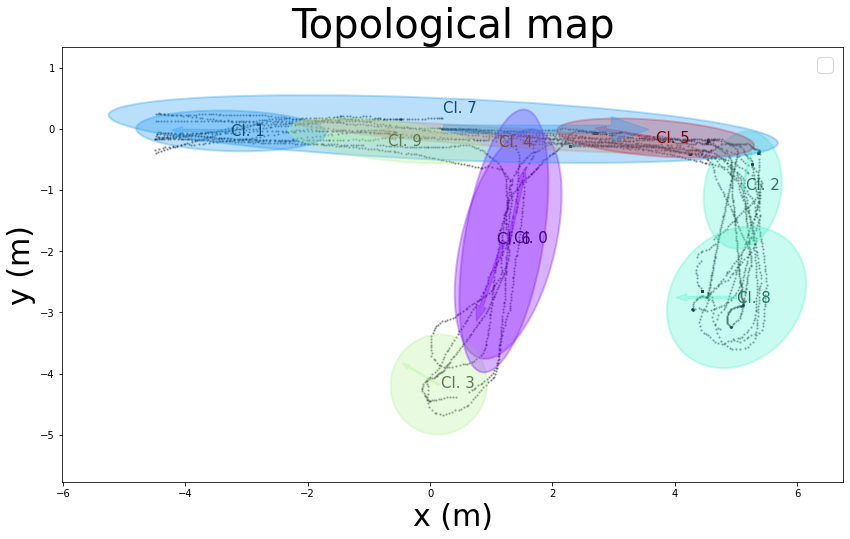

In [5]:
plot_utils.plot_map(abstracted_map, 
                    pose_data=poses_map, 
                    title='Topological map', 
                    plot_text=True)
plt.show()

No handles with labels found to put in legend.


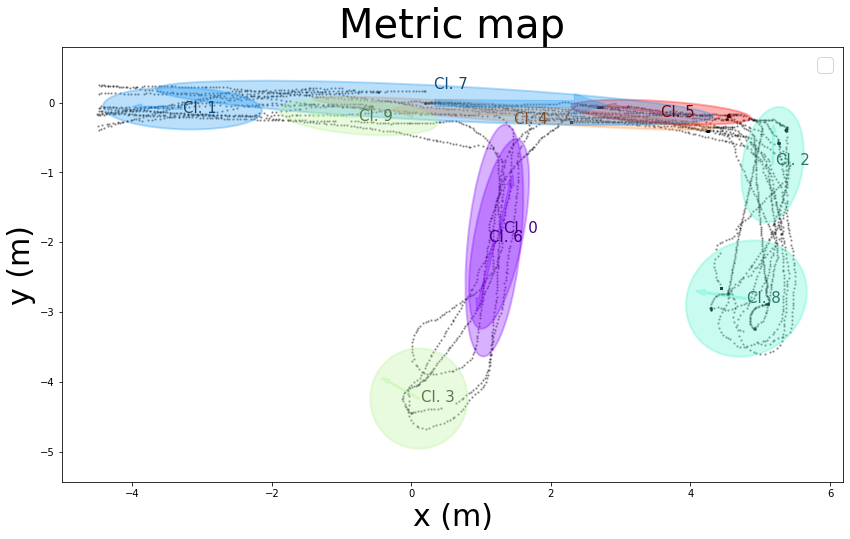

In [6]:
# Set the map
topometric_map = allom_map.ALLOMmap(poses_map, 
                                    feats_map,
                                    abstracted_map['mu_pose'],
                                    abstracted_map['mu_feat'],
                                    abstracted_map['cov_matrix'])

plot_utils.plot_map(topometric_map.get_params(), 
                    pose_data=poses_map, 
                    title='Metric map', 
                    plot_text=True)
plt.show()

# ALLOM

In [ ]:
pf = allom.ALLOMParticleFilter(100, topometric_map)
pf.verbose = True
pf.run(odoms_seq, feats_seq, gt_poses=poses_seq, init='vpr', step_incr=1, step_plot=10)

## Plot

In [ ]:
colors = plt.cm.rainbow(np.linspace(0, 1, topometric_map.numRegions // 2 + 1))
colors = np.concatenate([colors, colors, colors])

PLOT_STEP = 25
for i in range(0, len(pf.historial), PLOT_STEP):
    f, ax = plt.subplots(figsize=(10, 6))
    
    minx = poses_map.t()[:, 0].min()
    miny = poses_map.t()[:, 1].min()
    maxx = poses_map.t()[:, 0].max()
    maxy = poses_map.t()[:, 1].max()
    
    plt.xlim(minx, maxx)
    plt.ylim(miny, maxy)
    
    plt.scatter(pf.historial[i][:, 0], 
                pf.historial[i][:, 1], 
                s=(pf.historial[i][:, 2]**2)*1000, 
                c=colors[pf.historial[i][:, -1].astype(np.int)])
    
    plot_utils.plot_map(abstracted_map,
                        figure_handle=(f, ax),  
                        weights=pf.result[i][-1],
                        title='ALLOM step %d' % (i))
    
    str_gt = 'Ground truth' if i == 0 else None
    gt = pf.gt_poses[i*pf.step_incr]
    ang = gt.R().as_euler('xyz')[-1]
    plt.arrow(gt.t()[0], 
              gt.t()[1], 
              np.cos(ang) * 0.15, 
              np.sin(ang) * 0.15,
              facecolor='g',
              width=0.05, label=str_gt)
    
    str_estim = 'Estimation' if i == 0 else None
    estimation = pf.result[i][0]
    ang = estimation.R().as_euler('xyz')[-1]
    plt.arrow(estimation.t()[0], 
              estimation.t()[1], 
              np.cos(ang) * 0.1, 
              np.sin(ang) * 0.1,
              facecolor='r',
              width=0.035, label=str_estim)
        

    plt.axis('equal')
    plt.legend()
    plt.show()